# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [46]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [66]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [67]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [68]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    def is_relevant(user_idx, item_idx):
        return predicted[user_idx][item_idx] in relevant[user_idx]

    def average_precision(user_idx):
        relevant_count = 0
        sum_precision = 0.0

        for i in range(k):
            if i < len(predicted[user_idx]):
                if is_relevant(user_idx, i):
                    relevant_count += 1
                    sum_precision += relevant_count / (i + 1)

        max_relevant = min(k, len(relevant[user_idx]))
        return sum_precision / max_relevant if max_relevant > 0 else 0

    total_users = len(relevant)
    mean_avg_precision = np.mean([average_precision(user_idx) for user_idx in range(total_users)])

    return mean_avg_precision

In [69]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [70]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [71]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [72]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [73]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [74]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [75]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [76]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [77]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [78]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        predictions = []
        for user_id in range(self.n_users):
            user_recommendations = self.recommend(user_id)
            predictions.append(user_recommendations)

        # Удаление элементов, которые уже были в тренировочном наборе
        cleaned_predictions = self.remove_train_items(predictions, k)

        return cleaned_predictions

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [79]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = ratings @ user_vector.T
    denominator_users = np.apply_along_axis(lambda x: np.sqrt(np.sum(x)), 1, ratings)
    denominator_user_vector = np.sqrt(np.sum(user_vector))
    pearson = numerator / (denominator_user_vector * denominator_users)
    return pearson


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = ratings @ user_vector.T
    denominator_users = np.apply_along_axis(lambda x: np.sum(np.logical_or(x, user_vector)), 1, ratings)
    jaccard = numerator / denominator_users
    return jaccard

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [80]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """

        similarity_scores = self.similarity_func(self.R, user_vector)
        similarity_scores[similarity_scores <= self.alpha] = 0
        return similarity_scores

    def recommend(self, uid: int):
        user_similarity = self.similarity(self.R[uid])
        summed_sim = np.sum(np.abs(user_similarity))
        recommendation_scores = (self.R.T @ user_similarity) / summed_sim
        rec_score_sorted = np.argsort(recommendation_scores)[::-1]
        return rec_score_sorted

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [81]:
pearson_m = User2User(ratings, pearson)
jaccard_m = User2User(ratings, jaccard)


predictions_pearson = [pearson_m.recommend(i) for i in range(pearson_m.n_users)]
predictions_jaccard = [jaccard_m.recommend(i) for i in range(jaccard_m.n_users)]
predictions_random = [np.random.rand(pearson_m.n_items) for i in range(pearson_m.n_users)]

In [82]:
ks = np.arange(1, 120)

results_pearson = []
results_jaccard = []
results_random = []

for k in ks:
    results_pearson.append(mapk(test_relevant, predictions_pearson, k))
    results_jaccard.append(mapk(test_relevant, predictions_jaccard, k))
    results_random.append(mapk(test_relevant, predictions_random, k))

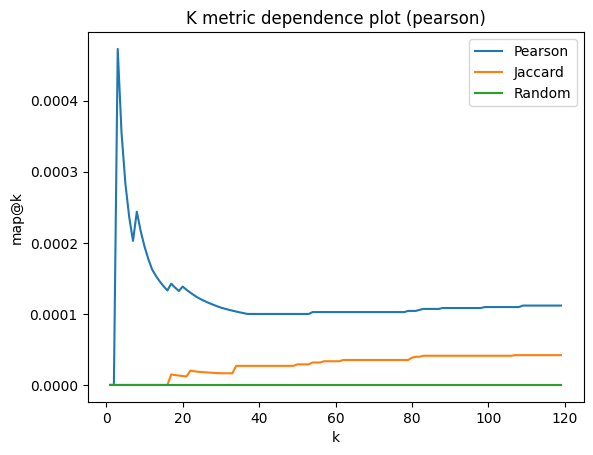

In [83]:
plt.plot(ks, results_pearson, label='Pearson')
plt.plot(ks, results_jaccard, label='Jaccard')
plt.plot(ks, results_random, label='Random')

plt.xlabel('k')
plt.ylabel('map@k')

plt.title('K metric dependence plot (pearson)')
plt.legend()

plt.show()

**Выводы:** наблюдается выход функций (как Жаккара, так и Пирсона) на плато с достижением определенного значения k (около 32-35). На протяжении всех значений k функция Пирсона показывает лучшее значение метрики, при этом при первых 10 k это значение было намного лучше значения функции Жакара.

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [84]:
from scipy import sparse

In [86]:
def pearson_sparse(ratings, user_vector):
    numerator = ratings @ user_vector.T
    denominator_users = np.sqrt(ratings.sum(axis=1))
    denominator_users_vector = np.sqrt(user_vector.sum())
    pearson_sp = numerator / (denominator_users * denominator_users_vector)
    return pearson_sp


def jaccard_sparse(ratings, user_vector):
    numerator = ratings @ user_vector.T
    denominator = ratings + sparse.csr_matrix(np.ones([ratings.shape[0], 1])) * user_vector
    denominator = (denominator > 0).sum(axis=1)
    jaccard_sp = numerator / denominator
    return jaccard_sp

class BaseModelSparse:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = ratings['userId'].nunique()
        self.n_items = ratings['trackId'].nunique()

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.R = sparse.csr_matrix(self.R)

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds, k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            filtered_preds = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
            new_preds[user_id, :len(filtered_preds)] = filtered_preds
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = [self.recommend(i) for i in range(self.n_users)]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds


class User2UserSparse(BaseModelSparse):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson_sparse, jaccard_sparse]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        similarity_scores = self.similarity_func(self.R, user_vector).toarray()
        similarity_scores[similarity_scores <= self.alpha] = 0

        return similarity_scores

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        user_similarity = sparse.csr_matrix(self.similarity(user_vector))
        summed_sim = np.sum(np.abs(user_similarity))
        recommendation_scores = (self.R.T @ user_similarity) / summed_sim
        recommendation_scores = recommendation_scores.T.toarray()[0]
        rec_score_sorted = np.argsort(recommendation_scores)[::-1]
        return rec_score_sorted

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [87]:
model = User2UserSparse(ratings, pearson_sparse)
user_id = np.random.randint(0, model.n_users)

In [88]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
61,Ain't No Mountain High Enough,"['Marvin Gaye', 'Tammi Terrell']"
177,Paper Planes,['M.I.A.']
186,Soon We'll Be Found,['Sia']
212,Let's Get It Started,['Black Eyed Peas']
220,I Was Made For Lovin' You,['Kiss']
222,I Go To Sleep,['Sia']
229,Linger,['The Cranberries']
234,Wind Of Change,['Scorpions']
418,Without Me,['Eminem']
582,The Winner Takes It All,['ABBA']


In [89]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
53877,Кристал нахт,['Purgen']
11502,"Baby, Its Cold Outside",['Rosemary Clooney']
48409,Седая ночь,['Саша Snek']
29287,Falling Back into the Blue,['Miller Anderson']
48750,Tears of the Lynx,['Banana Fish']
35944,Infinity,['Jaymes Young']
18104,Castles In The Air,['Gravitonas']
60781,Не забывай,['Гравита']
419,The Real Slim Shady,['Eminem']
50599,Did Ya Mama Ever Tell Ya,['Slade']


In [90]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
66746,Just for me,['PinkPantheress']
66782,Улетаю прочь,['Amirchik']
66806,Toxic,['BoyWithUke']
66808,internet l0ve nightcore,['gitarakuru']
66845,Ты со мной,"['Lina Lee', 'Ваня Дмитриенко']"
66861,dreamcore//,['Pathetic']
66874,У России три пути,"['GSPD', 'DEAD BLONDE']"
66887,GOLD MERCURY TOK,['Sekiz']
66937,Better wash my mouth out with the soap,['Sobertune']
66982,MONEY,['LISA']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

Функция потерь будет выглядеть следующим образом
$$
    L = \sum_{(u, i) \in R} (r_{ui} - p_u^Tq_i)^2 + \lambda \left(\sum_{u \in U} \| p_u \|^2_2 + \sum_{i \in I} \| q_i \|^2_2 \right)
$$

**LFM:**
Посчитаем градиент
$$
    \frac{\partial L}{\partial p_u} = -2 \sum_{(u, i)\colon \exists r_{ui}} \left[ (r_{ui} - p_uq_i^T)q_i \right] + 2 \lambda \sum_{u \in U} p_u
$$
$$
    \frac{\partial L}{\partial q_i} = -2 \sum_{(u, i)\colon \exists r_{ui}} \left[ (r_{ui} - p_uq_i^T)p_u \right] + 2 \lambda \sum_{i \in I} q_i
$$

Тогда будет обновлять параметры вот так
$$
    p_{u_k} = p_{u_k} + \eta \left( (r_{u_k i_k} - p_{u_k} q_{i_k}^T) q_{i_k} - \lambda p_{u_k} \right)
$$
$$
    q_{i_k} = q_{i_k} + \eta \left( (r_{u_k i_k} - p_{u_k} q_{i_k}^T) p_{u_k} - \lambda q_{i_k} \right)
$$


\\
**ALS:**
Выпишем аналитическое решение, так как функционал является выпуклым по Q при фиксированным P и по P при фиксированным Q
$$
    p_u = \left( \sum_{i\colon \exists r_{ui}} q_i q_i^T \right)^{-1} \sum_{i\colon \exists r_{ui}} r_{ui}q_i
$$
$$
    q_i = \left( \sum_{u\colon \exists r_{ui}} p_u p_u^T \right)^{-1} \sum_{i\colon \exists r_{ui}} r_{ui}p_u
$$

Если оставлять нефиксированный одну строку $p_k$ или $q_k$, то оптимальное решение для данной строки будет выглядеть следующим образом:
$$
    p_k = \frac{q_k \left( R - \sum_{s \neq k} p_s q_s^T \right)^T}{q_k q_k^T}
$$
$$
    q_k = \frac{p_k \left( R - \sum_{s \neq k} p_s q_s^T \right)^T}{p_k p_k^T}
$$


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [91]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, lr=0.0003, lamb=0.01, dim=128, mode='sgd', calc=True):
        super().__init__(ratings)

        self.lr = lr
        self.lamb = lamb
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.calc = calc
        self.predictions = []

    def perform_sgd(self, indexes):
      # Выполнение стохастического градиентного спуска
        for used_index, item_index in zip(indexes[0], indexes[1]):
            e = self.R[used_index][item_index] - self.P[used_index] @ self.Q[item_index].T
            self.P[used_index] += self.lr * (e * self.Q[item_index] - self.lamb * self.P[used_index])
            self.Q[item_index] += self.lr * (e * self.P[used_index] - self.lamb * self.Q[item_index])

    def perform_als(self, indexes):
      # Выполнение метода наименьших квадратов
        user_index = np.random.choice(indexes[0])
        item_index = np.random.choice(indexes[1])
        indexes_i = indexes[1][indexes[0] == user_index]
        Q_cut = self.Q[indexes_i]

        s_Q = np.zeros((Q_cut.shape[1], Q_cut.shape[1]))
        for item_index in indexes_i:
            s_Q += np.array([self.Q[item_index]]).T @ np.array([self.Q[item_index]])

        self.P[user_index] = np.linalg.inv(s_Q + self.lamb * np.eye(Q_cut.shape[1])) @ np.sum(Q_cut, axis=0)
        indexes_u = indexes[0][indexes[1] == item_index]
        P_cut = self.P[indexes_u]
        s_P = np.zeros((P_cut.shape[1], P_cut.shape[1]))
        for user_index in indexes_u:
            s_P += np.array([self.P[user_index]]).T @ np.array([self.P[user_index]])
        self.Q[item_index] = np.linalg.inv(s_P + self.lamb * np.eye(P_cut.shape[1])) @ np.sum(P_cut, axis=0)

    def fit(self, num_iters=5):
      # Обучение модели
        indexes = np.where(self.R == 1)
        for epoch in range(num_iters):
            if self.mode == 'sgd':
                self.perform_sgd(indexes)
            elif self.mode == 'als':
                self.perform_als(indexes)

    def recommend(self, uid):
      # Предсказание рейтингов для всех элементов для заданного пользователя
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [29]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [92]:
import optuna
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
optuna.logging.set_verbosity(optuna.logging.ERROR)

Подбор гиперпараметров для SGD

In [93]:
def ohvsgd(trial):
    params = {
        'lr': trial.suggest_float('lr', 0.0001, 0.01, step=(0.01 - 0.0001) / 5),
        'lamb': trial.suggest_float('lamb', 0.01, 1, step=0.02,),
        'dim': trial.suggest_int('dim', 64, 512, step=(512 - 64) / 5),
        'mode': 'sgd',
        'calc': False,
    }

    hidden_vars_sgd_model = HiddenVars(train_ratings, **params)
    hidden_vars_sgd_model.fit(8)
    recommendations = [hidden_vars_sgd_model.recommend(i) for i in test_users]
    return mapk(test_relevant, recommendations)
def ohvals(trial):
    params = {
        'lamb': trial.suggest_float('lamb', 0.01, 1, step=0.02,),
        'dim': trial.suggest_int('dim', 64, 512, step=(512 - 64) / 5),
        'mode': 'als',
        'calc': False,
    }

    hidden_vars_als_model = HiddenVars(train_ratings, **params)
    hidden_vars_als_model.fit(8)
    recommendations = [hidden_vars_als_model.recommend(i) for i in test_users]
    return mapk(test_relevant, recommendations)

In [32]:
hvsgd_test = optuna.create_study(direction='maximize')
hvsgd_test.optimize(ohvsgd, n_trials=15)

hvsgd_test.best_params

{'lr': 0.0001, 'lamb': 0.81, 'dim': 242}

Для ALS

In [35]:
hvals_test = optuna.create_study(direction='maximize')
hvals_test.optimize(ohvals, n_trials=15)

hvals_test.best_params

{'lamb': 0.25, 'dim': 64}

Обучим SGD в соответствии с новыми параметрами

In [94]:
hvsgd_model = HiddenVars(train_ratings, lr=0.0001, lamb=0.81, dim=242, mode='sgd')
hvsgd_model.fit(15)

predictions_sgd = [hvsgd_model.recommend(i) for i in range(hvsgd_model.n_users)]

results_sgd = []

for k in ks:
    results_sgd.append(mapk(test_relevant, predictions_sgd, k))

Аналогично с ALS

In [96]:
hvals_model = HiddenVars(train_ratings, lamb=0.25, dim=64, mode='als')
hvals_model.fit(15)

predictions_als = [hvals_model.recommend(i) for i in range(hvals_model.n_users)]

results_als = []

for k in ks:
    results_als.append(mapk(test_relevant, predictions_als, k))

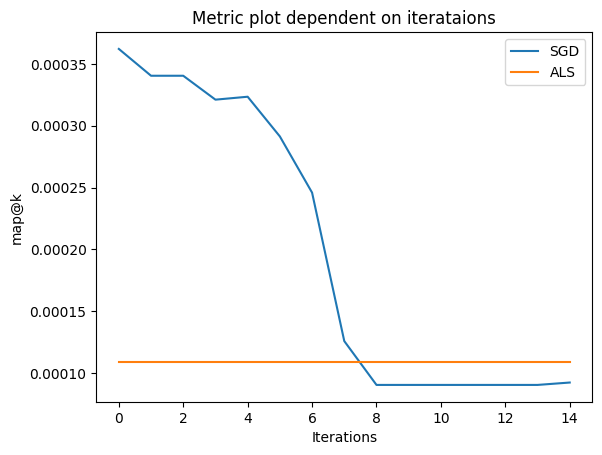

In [38]:
plt.plot(range(len(hvsgd_model.predictions)), hvsgd_model.predictions, label='SGD')
plt.plot(range(len(hvals_model.predictions)), hvals_model.predictions, label='ALS')

plt.xlabel('Iterations')
plt.ylabel('map@k')

plt.title('Metric plot dependent on iterataions')
plt.legend()

plt.show()

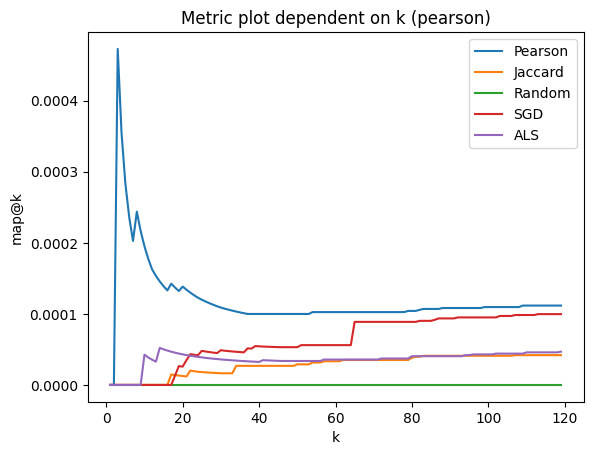

In [40]:
plt.plot(ks, results_pearson, label='Pearson')
plt.plot(ks, results_jaccard, label='Jaccard')
plt.plot(ks, results_random, label='Random')
plt.plot(ks, results_sgd, label='SGD')
plt.plot(ks, results_als, label='ALS')

plt.xlabel('k')
plt.ylabel('map@k')

plt.title('Metric plot dependent on k (pearson)')
plt.legend()

plt.show()

**Выводы**: можно увидеть, что песни подобрались довольно качественно. Например, по ALS и SGD значение метрики лучше, чем у Жаккара

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [44]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = hvsgd_model.Q @ hvsgd_model.Q[example_trackId]
preds = preds / np.sqrt((hvsgd_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [45]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(hvsgd_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
24310,Worth It (Dame Esta Noche),"['Fifth Harmony', 'Kid Ink']",0.277052
19345,Мне трудно говорить,['REFLEX'],0.256187
61010,Waves,"['KANG DANIEL', 'Simon Dominic', 'Jamie']",0.252154
957,Who Knows Where The Time Goes?,['Fairport Convention'],0.251720
5193,Maria Magdalena,['Sandra'],0.245902
36512,Как Ты Танцевала,['Витя АК'],0.239639
44115,Девушки фабричные,['Фабрика'],0.233243
57782,Brass Devil,['Parov Stelar'],0.231192
4730,Brand New Day,['Ryan Star'],0.227751
